In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
plt.style.use('ggplot')

In [7]:
model_number = 'p1500'

In [8]:
df = pd.read_csv(f"csv_output/{model_number}_2022.csv", converters={
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
})

In [10]:
df.head(4)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,150000.0,1.0,14.0,1000000.0,0.0,23.600006,0.644089,62.261013,1805598.4,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[12.166210174560547, 15.3733491897583, 0.068...","[[[[59735.26953125, 59730.6640625, 59724.96875...","[[36.570152282714844, 7.267686367034912, 0.0, ...","[[[59865.74609375, 59723.1015625, 59722.976562...",-1.0
1,1.0,150000.0,2.0,14.0,1000000.0,0.0,23.600006,-4.511144,25.749134,2242489.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[43.019287109375, 52.589237213134766, 75.666...","[[[[74306.4609375, 74297.7734375, 74294.640625...","[[185.86007690429688, 58.547847747802734, 31.4...","[[[74329.375, 74293.6640625, 74293.625, 74300....",-1.0
2,2.0,150000.0,3.0,14.0,1000000.0,0.0,23.600006,-30.959814,17.152563,1505588.8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[240.13302612304688, 232.70599365234375, 310...","[[[[49961.23046875, 49713.765625, 49712.980468...","[[1068.0518798828125, 838.308837890625, 388.49...","[[[49961.23046875, 49712.8984375, 49712.789062...",-1.0
3,3.0,150000.0,4.0,14.0,1000000.0,0.0,23.600006,-16.802952,-52.738407,2791880.8,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[23.42307472229004, 0.39007124304771423, 7.5...","[[[[92628.9140625, 92623.6015625, 92621.726562...","[[31.386062622070312, 37.29946517944336, 19.21...","[[[92652.84375, 92623.6015625, 92621.7265625, ...",-1.0


In [11]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


## положение оси $X_0, Y_0$ 
$$
X_0 = \frac{\sum X_i \cdot m_i}{m_i}
$$

$$
Y_0 = \frac{\sum Y_i \cdot m_i}{m_i} 
$$

In [12]:
j_event = 2

In [13]:
E_1_event = df['EdepStNE'].iloc[j_event]

theta = df['Teta'].iloc[j_event]
phi = df['Fi'].iloc[j_event]

X0_corsika = df['XAxisShift'].iloc[j_event]
Y0_corsika = df['YAxisShift'].iloc[j_event]

Ne_corsika = df['NeNKGlong'].iloc[j_event]
s_corsika = df['sNKGlong'].iloc[j_event]

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']

In [14]:
e_list = []
for i_cluster, cluster in enumerate(E_1_event):
    for j_station, value in enumerate(cluster):
        e_list.append(
            {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

E_stations = pd.DataFrame(e_list)
E_stations.head(2)

,cluster,station,E
0,1,1,1068.051880
1,1,2,838.308838


In [15]:
X0 = np.sum(X * E_stations['E']) / np.sum(E_stations['E'])
Y0 = np.sum(Y * E_stations['E']) / np.sum(E_stations['E'])

In [16]:
print(X0, Y0)

-24.704896921761396 14.072522695816263


In [17]:
Z0 = -18

## $r$
Ось ШАЛ:

$
 \begin{cases}
X = X_0 + ct \cos{\phi}\sin{\theta} \\
Y = Y_0 + ct \sin{\phi}\sin{\theta} \\
Z = Z_0 + ct \cos{\theta}
 \end{cases}
$

Пусть станция имеет координаты $(X_s,Y_s,Z_s)$

$
r = \frac{|\vec{v} \times (P - P_0)|}{|\vec{v}|}
$

$ P_0​=(X_0​,Y_0​,Z_0​) $ — точка на оси ШАЛ

$ P = (X_s,Y_s,Z_s) $ — координаты станции

$ \vec{v}=(\cos⁡{\phi}\sin{\theta},\sin⁡{\phi}\sin⁡{\theta}, \cos⁡{\theta})$ — направляющий вектор оси ШАЛ


In [18]:
def compute_r(X0, Y0, Z0, theta, phi, coordinates_df, c=2.99e8):
    """
    Вычисляет перпендикулярное расстояние от детектора до оси ШАЛ в момент пересечения
    плоскости ШАЛ с детектором.

    Параметры:
      X0, Y0, Z0: координаты оси ШАЛ на земле (в метрах)
      theta, phi: углы направления оси ШАЛ (в градусах)
      coordinates_df: DataFrame с координатами детекторов (столбцы 'X', 'Y', 'Z', в метрах)
      c: скорость света (по умолчанию 2.99e8 м/с)

    Возвращает:
      Массив расстояний r для каждого детектора.
    """
    # Перевод углов в радианы
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)

    # Единичный вектор направления оси ШАЛ
    v = np.array([np.cos(phi_rad) * np.sin(theta_rad),
                  np.sin(phi_rad) * np.sin(theta_rad),
                  np.cos(theta_rad)])

    # Точка на оси ШАЛ (на земле)
    Q = np.array([X0, Y0, Z0])

    # Координаты детекторов (Nx3)
    P = np.vstack(
        (coordinates_df['X'], coordinates_df['Y'], coordinates_df['Z'])).T

    # Для каждого детектора находим время t, когда плоскость ШАЛ проходит через него.
    # Уравнение: (P - Q)·v = t * c  =>  t = ((P - Q)·v) / c
    t_values = np.dot(P - Q, v) / c

    # Положение на оси ШАЛ в момент прохождения плоскости через детектор:
    # Q + t * c * v   (при этом t*c = (P-Q)·v, но мы оставляем вычисление явно)
    P_intersect = Q + np.outer(t_values * c, v)

    # Перпендикулярное расстояние от детектора до оси (расстояние от P до P_intersect)
    r = np.linalg.norm(P - P_intersect, axis=1)

    return r

In [68]:
r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)

## $\rho$

$ N_e = \frac{E}{8.2 \text{MeV}} $

$ S = 0.8 \times 0.8 \times 4 $ 

$ \rho = \frac{N_e}{S} $


In [105]:
N_e = E_stations['E'] / 8.2
mask = N_e > 5
N_e = N_e[mask]
S = 0.8 * 0.8 * 4


rho = N_e/S

In [106]:
len(rho)

21

In [107]:
rho_log = np.log10(rho)

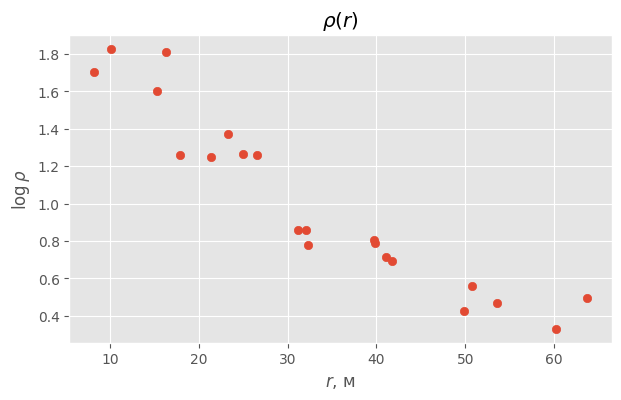

In [108]:
plt.figure(figsize=(7, 4))
plt.scatter(r[mask], rho_log)
plt.xscale("linear")
# plt.yscale("log")
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\log{\rho}$')
plt.title(r'$\rho(r)$')
plt.show()

## функция пространственного распределения электронов

$ \rho(r) = \frac{N_e}{2\pi r_m^2} (\frac{r}{r_m})^{s-2}(1+\frac{r}{r_m})^{s-4.5} \frac{\Gamma(4.5-s)}{\Gamma(s)\Gamma(4.5-2s)}$

$ r_m = 79$

In [109]:
def rho_model(r, Ne, s, r_m=79):
    term1 = Ne / (2 * np.pi * r_m**2)
    term2 = (r / r_m) ** (s - 2)
    term3 = (1 + r / r_m) ** (s - 4.5)
    term4 = gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return term1 * term2 * term3 * term4

In [110]:
def log_rho_model(r, Ne, s, r_m=80):
    log_term1 = np.log(Ne) - np.log(2 * np.pi * r_m**2)
    log_term2 = (s - 2) * np.log(r / r_m)
    log_term3 = (s - 4.5) * np.log(1 + r / r_m)
    log_term4 = gammaln(4.5 - s) - gammaln(s) - gammaln(4.5 - 2 * s)
    return log_term1 + log_term2 + log_term3 + log_term4


def rho_model_exp(r, Ne, s, r_m=80):
    return np.exp(log_rho_model(r, Ne, s, r_m))

In [111]:
import math

In [112]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    # return np.mean((rho_calc - rho) ** 2)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)


def loss_function_s(params, X0, Y0, Ne, coordinates_df, rho, theta, phi, Z0):
    s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model_exp(r, Ne, s)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)


def loss_function_Ne(params, X0, Y0, s, coordinates_df, rho, theta, phi, Z0):
    Ne = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)

In [153]:
# Начальные приближения параметров
initial_params = [X0,  Y0,  2.0e8, 2]  # X0, Y0, Ne, s
bounds = [
    (-50, 50),
    (-80, 80),
    (1, 1e8),
    (0.2, 2)
]  # Границы для оптимизации

initial_params_s = [1.5]  # X0, Y0, Ne, s
bounds_s = [
    (0.2, 2)
]

initial_params_Ne_s = [1e8, 1.5]  # X0, Y0, Ne, s
bounds_Ne_s = [
    (1, 1e8),
    (0.7, 2)
]  # Границы для оптимизации

In [154]:
l = int(len(rho) / 2)
len(rho[:l])

10

In [159]:
result_global = differential_evolution(loss_function, bounds,
                                       args=(coordinates_df[mask], rho, theta, phi, Z0))
print("Результат глобального поиска:", result_global.x)

# Этап 2. Локальная оптимизация (например, методом L-BFGS-B) с начальным приближением из глобального поиска:
result_local = minimize(loss_function, result_global.x, args=(coordinates_df[mask], rho, theta, phi, Z0),
                        method='SLSQP', bounds=bounds)
print("Результат локальной оптимизации:", result_local.x)

X0_opt, Y0_opt, Ne_opt, s_opt = result_local.x

Результат глобального поиска: [-3.04639053e+01  1.61994900e+01  2.06992149e+05  1.09814485e+00]
Результат локальной оптимизации: [-3.04639053e+01  1.61994900e+01  2.06992149e+05  1.09814485e+00]


In [160]:
result_s = minimize(loss_function, initial_params, args=(
    coordinates_df[mask], rho, theta, phi, Z0), bounds=bounds, method="SLSQP")

X1, Y1, Ne1, s_SLSQP = result_s.x
print(
    f'Оптимальные параметр X={X1:.3f}, Y={Y1:.3f}, Ne={Ne1:e}, s={s_SLSQP:.3f}')

X0_opt, Y0_opt, Ne_opt, s_opt = X0_opt, Y0_opt, Ne_opt, s_SLSQP

Оптимальные параметр X=-50.000, Y=80.000, Ne=1.000000e+08, s=2.000


In [157]:
initial_params_Ne = [Ne_opt]
bounds_Ne = [
    (1, 1e8),
]

initial_params_s = [s_opt]
bounds_s = [
    (0.8, 2),
]

In [158]:
result_Ne = differential_evolution(loss_function_Ne, bounds=bounds_Ne, args=(
    X0_opt, Y0_opt, s_opt, coordinates_df[mask], rho, theta, phi, Z0))
Ne_opt = result_Ne.x[0]
print(f'{Ne_opt:.3e}')

1.272e+06


In [90]:
l2 = int(l / 2)

In [161]:
print(f'{X0_corsika:.3f}, {X0:.3f}, {X0_opt:.3f}')
print(f'{Y0_corsika:.3f}, {Y0:.3f}, {Y0_opt:.3f}')

print(f"Ne_corsika = {Ne_corsika:.1e}, Ne_opt = {Ne_opt:.1e}")
print(f"s_corsika = {s_corsika:.3f}, s_opt = {s_opt:.3f}")

-30.960, -24.705, -30.464
17.153, 14.073, 16.199
Ne_corsika = 1.6e+05, Ne_opt = 2.1e+05
s_corsika = 1.293, s_opt = 2.000


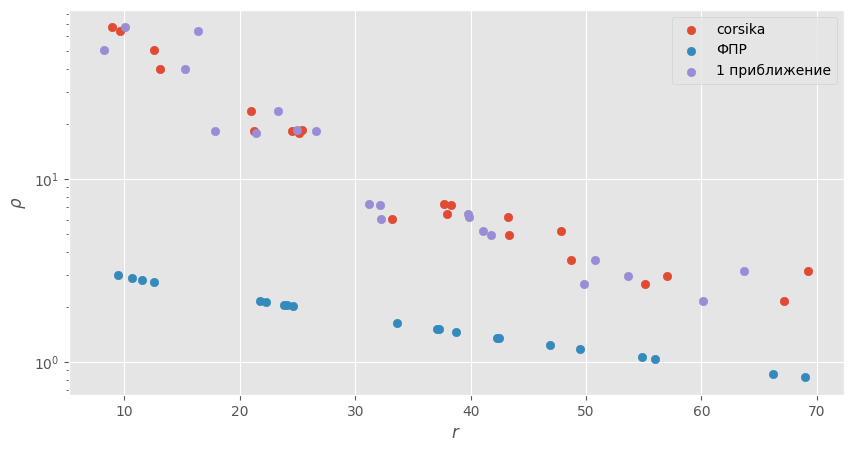

In [162]:
r_opt = compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df[mask])
r_corsika = compute_r(X0_corsika, Y0_corsika, Z0,
                      theta, phi, coordinates_df[mask])
rho_fit = rho_model(r_opt, Ne_opt, s_opt)

plt.figure(figsize=(10, 5))
plt.scatter(r_corsika, rho, label="corsika")

plt.scatter(r_opt, rho_fit, label="ФПР")

plt.scatter(r[mask], rho, label="1 приближение")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

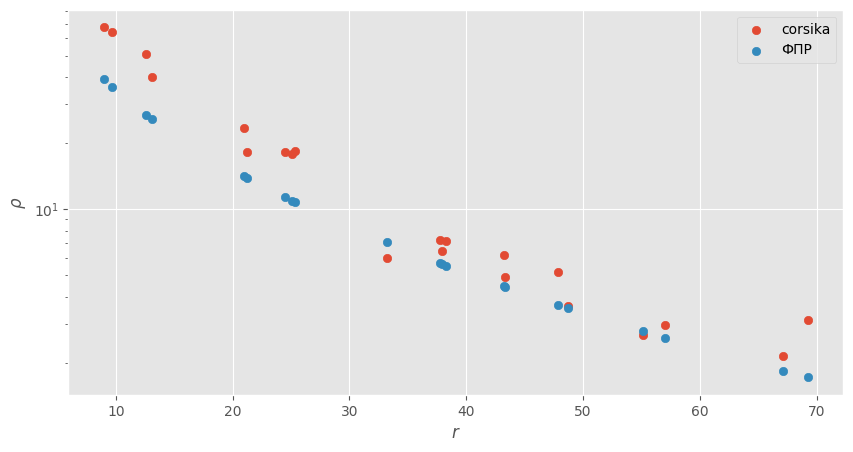

In [163]:
rho_corsika_fit = rho_model(r_corsika, Ne_corsika, s_corsika)

plt.figure(figsize=(10, 5))
plt.scatter(r_corsika, rho, label="corsika")

plt.scatter(r_corsika, rho_corsika_fit, label="ФПР")

plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

In [515]:
result = differential_evolution(loss_function, bounds, args=(
    coordinates_df, rho_corsika_fit, theta, phi, Z0))

In [516]:
X0_opt, Y0_opt, Ne_opt, s_opt = result.x
print(
    f"Оптимальные параметры: X0={X0_opt}, Y0={Y0_opt}, Ne={Ne_opt}, s={s_opt}")

Оптимальные параметры: X0=-19.320170000000005, Y0=46.458084, Ne=6574410.0, s=1.355909


In [165]:
r_opt_array = []
r_corsika_array = []

Ne_opt_array = []
s_opt_array = []

rho_corsika_array = []

In [166]:
for j_event, event in tqdm(df.iterrows(), total=len(df), desc='~'):

    E_1_event = df['EdepStNE'].iloc[j_event]

    theta = df['Teta'].iloc[j_event]
    phi = df['Fi'].iloc[j_event]

    X0_corsika = df['XAxisShift'].iloc[j_event]
    Y0_corsika = df['YAxisShift'].iloc[j_event]

    Ne_corsika = df['NeNKGlong'].iloc[j_event]
    s_corsika = df['sNKGlong'].iloc[j_event]

    X = coordinates_df['X']
    Y = coordinates_df['Y']
    Z = coordinates_df['Z']

    e_list = []
    for i_cluster, cluster in enumerate(E_1_event):
        for j_station, value in enumerate(cluster):
            e_list.append(
                {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

    E_stations = pd.DataFrame(e_list)

    N = E_stations['E'] / 8.2
    mask = N > 5
    N = N[mask]
    rho = (N / (0.8 * 0.8 * 4))

    result_global = differential_evolution(
        loss_function,
        bounds,
        args=(coordinates_df[mask], rho, theta, phi, Z0)
    )

    result_local = minimize(
        loss_function,
        result_global.x,
        args=(coordinates_df[mask], rho, theta, phi, Z0),
        method='SLSQP',
        bounds=bounds
    )

    X0_opt, Y0_opt, Ne_opt, s_opt = result_local.x

    # result_s = minimize(
    #     loss_function,
    #     initial_params,
    #     args=(coordinates_df, rho, theta, phi, Z0),
    #     bounds=bounds,
    #     method="SLSQP"
    # )
    # X1, Y1, Ne1, s_SLSQP = result_s.x
    # X0_opt, Y0_opt, Ne_opt, s_opt = X0_opt, Y0_opt, Ne_opt, s_SLSQP

    # initial_params_Ne = [Ne_opt]
    # bounds_Ne = [
    #     (1, 1e8),
    # ]

    # initial_params_s = [s_opt]
    # bounds_s = [
    #     (0.8, 2),
    # ]

    # result_Ne = differential_evolution(loss_function_Ne, bounds=bounds_Ne, args=(
    #     X0_opt, Y0_opt, s_opt, coordinates_df, rho, theta, phi, Z0))
    # Ne_opt = result_Ne.x[0]

    r_opt_array.append(
        compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df[mask]))
    r_corsika_array.append(
        compute_r(X0_corsika, Y0_corsika, Z0, theta, phi, coordinates_df[mask]))

    Ne_opt_array.append(Ne_opt)
    s_opt_array.append(s_opt)

    rho_corsika_array.append(rho)

~: 100%|██████████| 1000/1000 [36:28<00:00,  2.19s/it] 


In [ ]:
r_opt = np.concatenate(r_opt_array)
r_corsika = np.concatenate(r_corsika_array)

rho_corsika = np.concatenate(rho_corsika_array)

In [168]:
delta_r = r_opt - r_corsika
delta_s = np.array(s_opt_array) - np.array(df['sNKGlong'])
delta_Ne = (np.array(Ne_opt_array) -
            np.array(df['NeNKGlong'])) / np.array(df['NeNKGlong'])

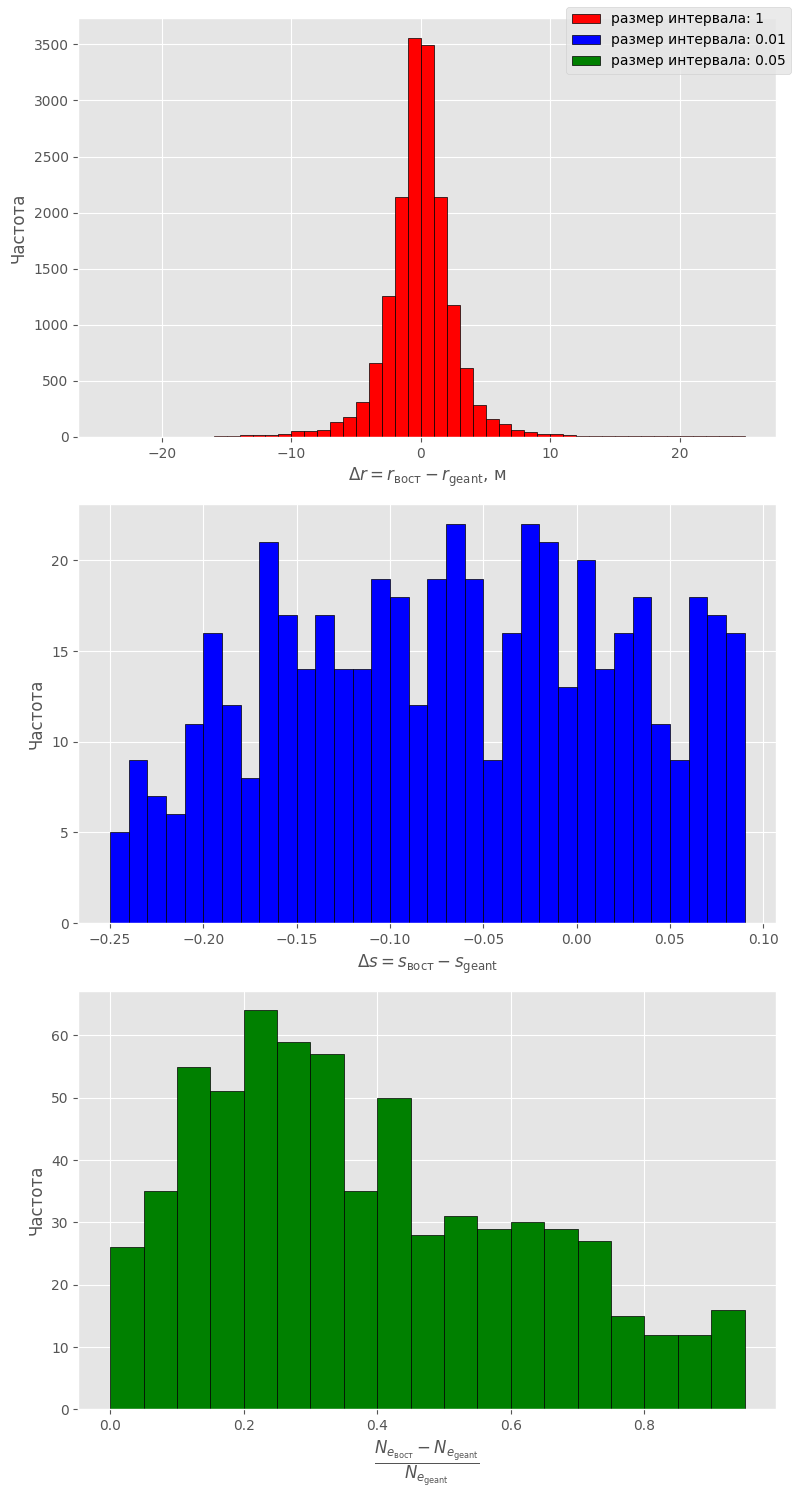

In [171]:
interval_delta_r = 1
interval_delta_s = 0.01
interval_delta_Ne = 0.05

bin_edges_delta_r = np.arange(-24, 26, interval_delta_r)
bin_edges_delta_s = np.arange(-0.25, 0.1, interval_delta_s)
bin_edges_delta_Ne = np.arange(0, 1, interval_delta_Ne)

fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# delta_r
axes[0].hist(delta_r, bins=bin_edges_delta_r,
             edgecolor='black', color='red', label=f'размер интервала: {interval_delta_r}')
axes[0].set_xlabel(r'$\Delta r = r_{\text{вост}} - r_{\text{geant}}$, м')
axes[0].set_ylabel("Частота")
# delta_s
axes[1].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
             color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1].set_xlabel(r'$\Delta s = s_{\text{вост}} - s_{\text{geant}}$')
axes[1].set_ylabel("Частота")

# delta_Ne
axes[2].hist(delta_Ne, bins=bin_edges_delta_Ne,
             edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[2].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{geant}}}}{N_{e_{\text{geant}}}}$')
axes[2].set_ylabel("Частота")

fig.legend()

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(f'plots/{model_number}/delta_r,s,Ne.png',
            dpi=500, bbox_inches="tight")
plt.show()

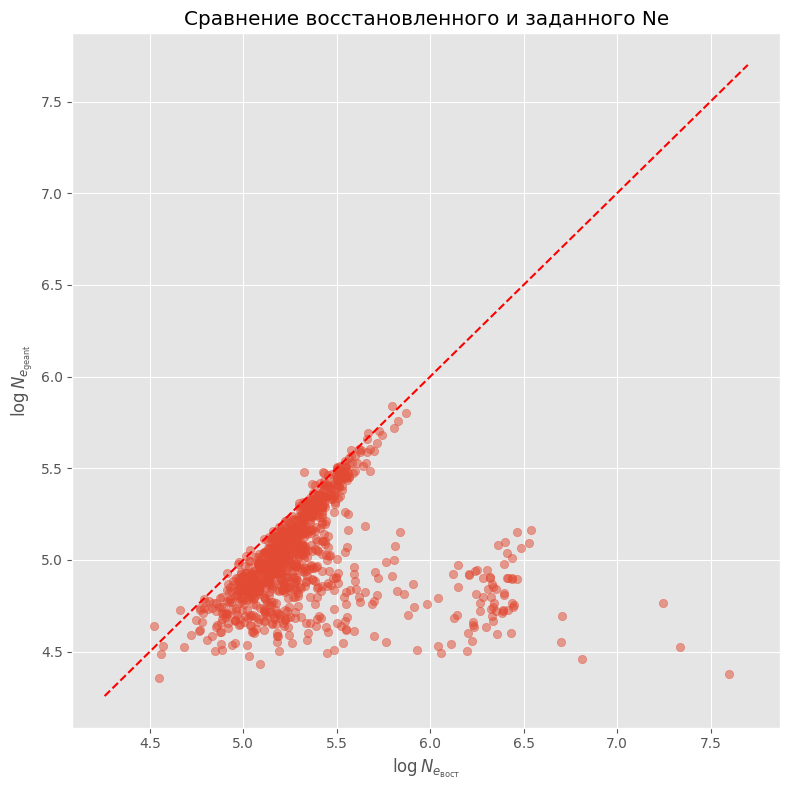

In [172]:
Ne_corsika_array = np.array(df['NeNKGlong'])

log_Ne_opt = np.log10(Ne_opt_array)
log_Ne_corsika = np.log10(Ne_corsika_array)

plt.figure(figsize=(8, 8))
plt.scatter(log_Ne_opt, log_Ne_corsika, alpha=0.5)

min_value = min(log_Ne_opt.min(), log_Ne_corsika.min()) - 0.1
max_value = max(log_Ne_opt.max(), log_Ne_corsika.max()) + 0.1
plt.plot([min_value, max_value], [min_value, max_value],
         color='red', linestyle='--')

plt.xlabel(r'$\log{N_{e_{\text{вост}}}}$')
plt.ylabel(r'$\log{N_{e_{\text{geant}}}}$')
plt.title('Сравнение восстановленного и заданного Ne')

plt.tight_layout()
plt.savefig(f"plots/{model_number}/log_Ne_scatter.png",
            dpi=500, bbox_inches="tight")

plt.show()

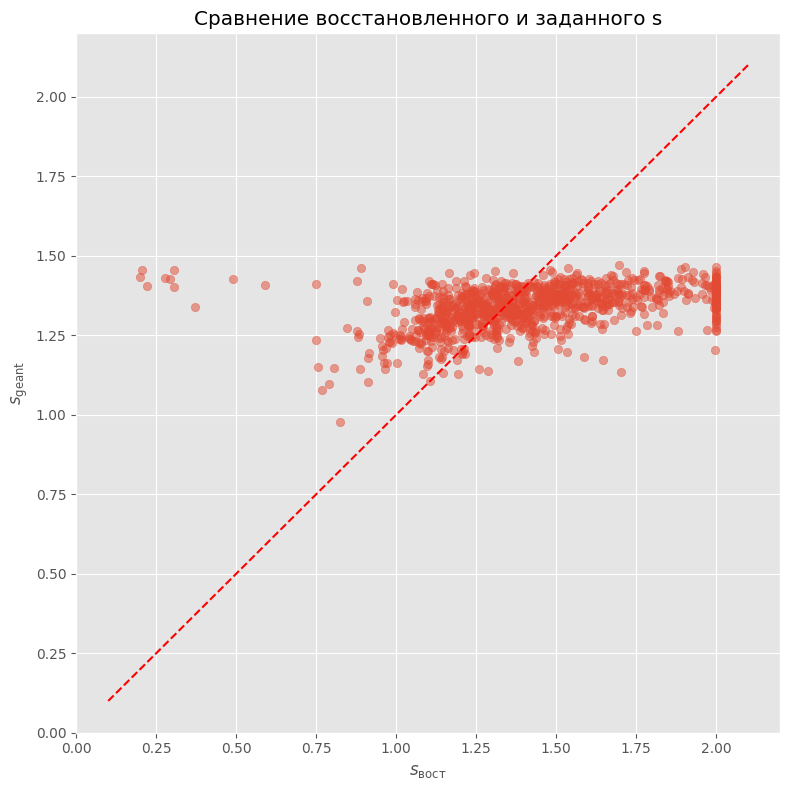

In [173]:
s_corsika_array = np.array(df['sNKGlong'])
s_opt_array = np.array(s_opt_array)

plt.figure(figsize=(8, 8))

plt.scatter(s_opt_array, s_corsika_array, alpha=0.5)

min_value = min(s_opt_array.min(), s_corsika_array.min()) - 0.1
max_value = max(s_opt_array.max(), s_corsika_array.max()) + 0.1
plt.plot([min_value, max_value], [min_value, max_value],
         color='red', linestyle='--',)

plt.xlabel(r'$s_{\text{вост}}$')
plt.ylabel(r'$s_{\text{geant}}$')
plt.title('Сравнение восстановленного и заданного s')

plt.tight_layout()
plt.savefig(f"plots/{model_number}/s_scatter.png",
            dpi=500, bbox_inches="tight")

plt.show()

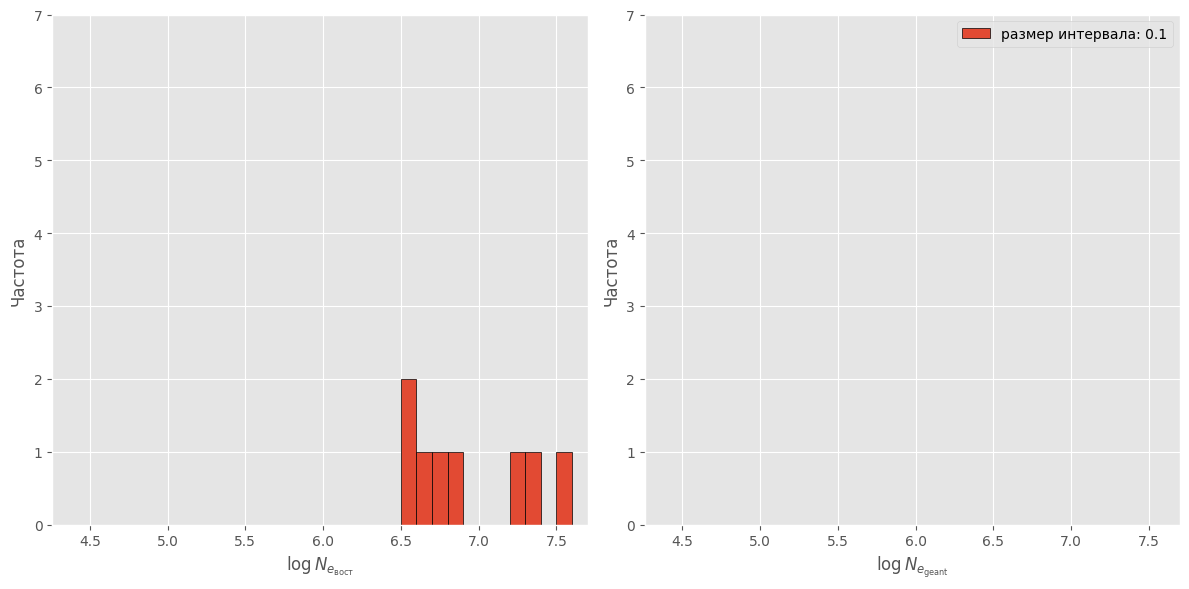

In [174]:
log_Ne_opt_array = np.log10(Ne_opt_array)
log_Ne_corsika_array = np.log10(np.array(df['NeNKGlong']))

interval_log_Ne = 0.1
bin_edges_log_Ne = np.arange(6.5, 8, interval_log_Ne)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(log_Ne_opt_array, bins=bin_edges_log_Ne, edgecolor='black')
axes[0].set_xlabel(r'$\log{N_{e_{\text{вост}}}}$')
axes[0].set_ylabel("Частота")

axes[1].hist(log_Ne_corsika_array, bins=bin_edges_log_Ne,
             edgecolor='black', label=f'размер интервала: {interval_log_Ne}')
axes[1].set_xlabel(r'$\log{N_{e_{\text{geant}}}}$')
axes[1].set_ylabel("Частота")
axes[1].legend()

x_min = min(log_Ne_opt_array.min(), log_Ne_corsika_array.min()) - 0.1
x_max = max(log_Ne_opt_array.max(), log_Ne_corsika_array.max()) + 0.1
y_max = max(np.histogram(log_Ne_opt_array, bins=bin_edges_log_Ne)[0].max(),
            np.histogram(log_Ne_corsika_array, bins=bin_edges_log_Ne)[0].max()) + 5

axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([0, y_max])
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([0, y_max])

data = pd.DataFrame({'log_Ne_opt': log_Ne_opt_array,
                    'log_Ne_corsika': log_Ne_corsika_array})
data.to_csv(f'plots/{model_number}/log_Ne.csv', index=False)

plt.tight_layout()
plt.savefig(f"plots/{model_number}/log_Ne.png", dpi=500, bbox_inches="tight")

plt.show()

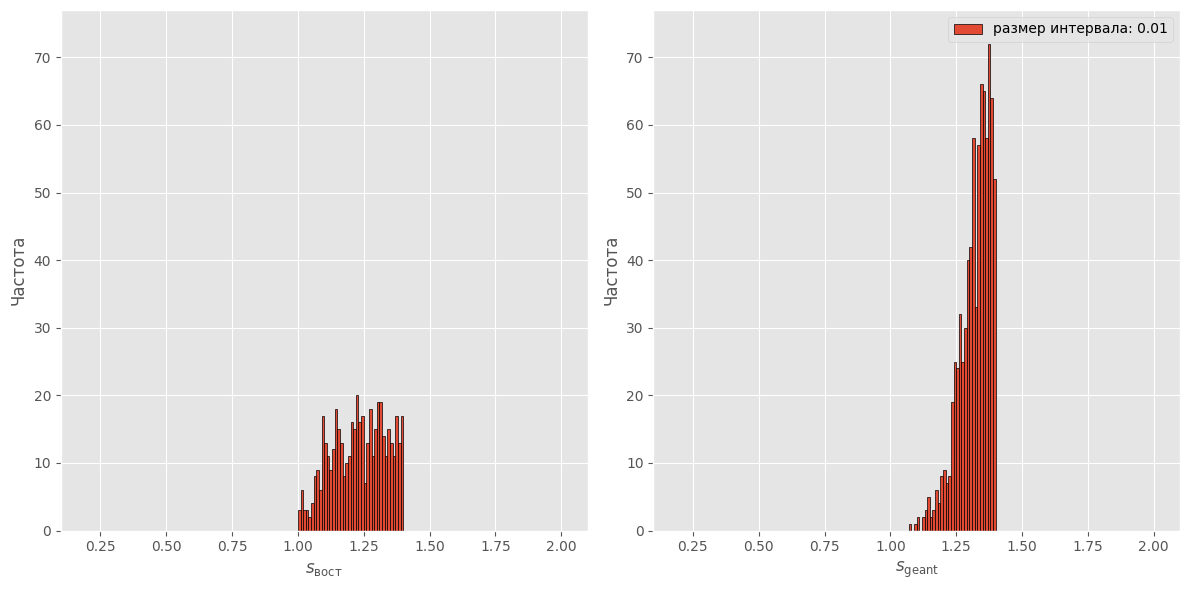

In [175]:
interval_s = 0.01

bin_edges_s_opt = np.arange(1.0, 1.41, interval_s)
bin_edges_s_corsika = np.arange(1.0, 1.41, interval_s)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# востановленный s
axes[0].hist(s_opt_array, bins=bin_edges_s_opt, edgecolor='black')
axes[0].set_xlabel(r'$s_{\text{вост}}$')
axes[0].set_ylabel("Частота")

# заданный s
axes[1].hist(df['sNKGlong'],
             bins=bin_edges_s_corsika, edgecolor='black', label=f'размер интервала: {interval_s}')
axes[1].set_xlabel(r'$s_{\text{geant}}$')
axes[1].set_ylabel("Частота")
axes[1].legend()

x_min = min(min(s_opt_array), df['sNKGlong'].min()) - 0.1
x_max = max(max(s_opt_array), df['sNKGlong'].max()) + 0.1
y_max = max(np.histogram(s_opt_array, bins=bin_edges_s_opt)[0].max(),
            np.histogram(df['sNKGlong'], bins=bin_edges_s_corsika)[0].max()) + 5

axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([0, y_max])
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([0, y_max])

data = pd.DataFrame(
    {'s_opt': s_opt_array, 's_corsika': df['sNKGlong']})
data.to_csv(f'plots/{model_number}/s.csv', index=False)

plt.tight_layout()
plt.savefig(f"plots/{model_number}/s.png", dpi=500, bbox_inches="tight")

plt.show()

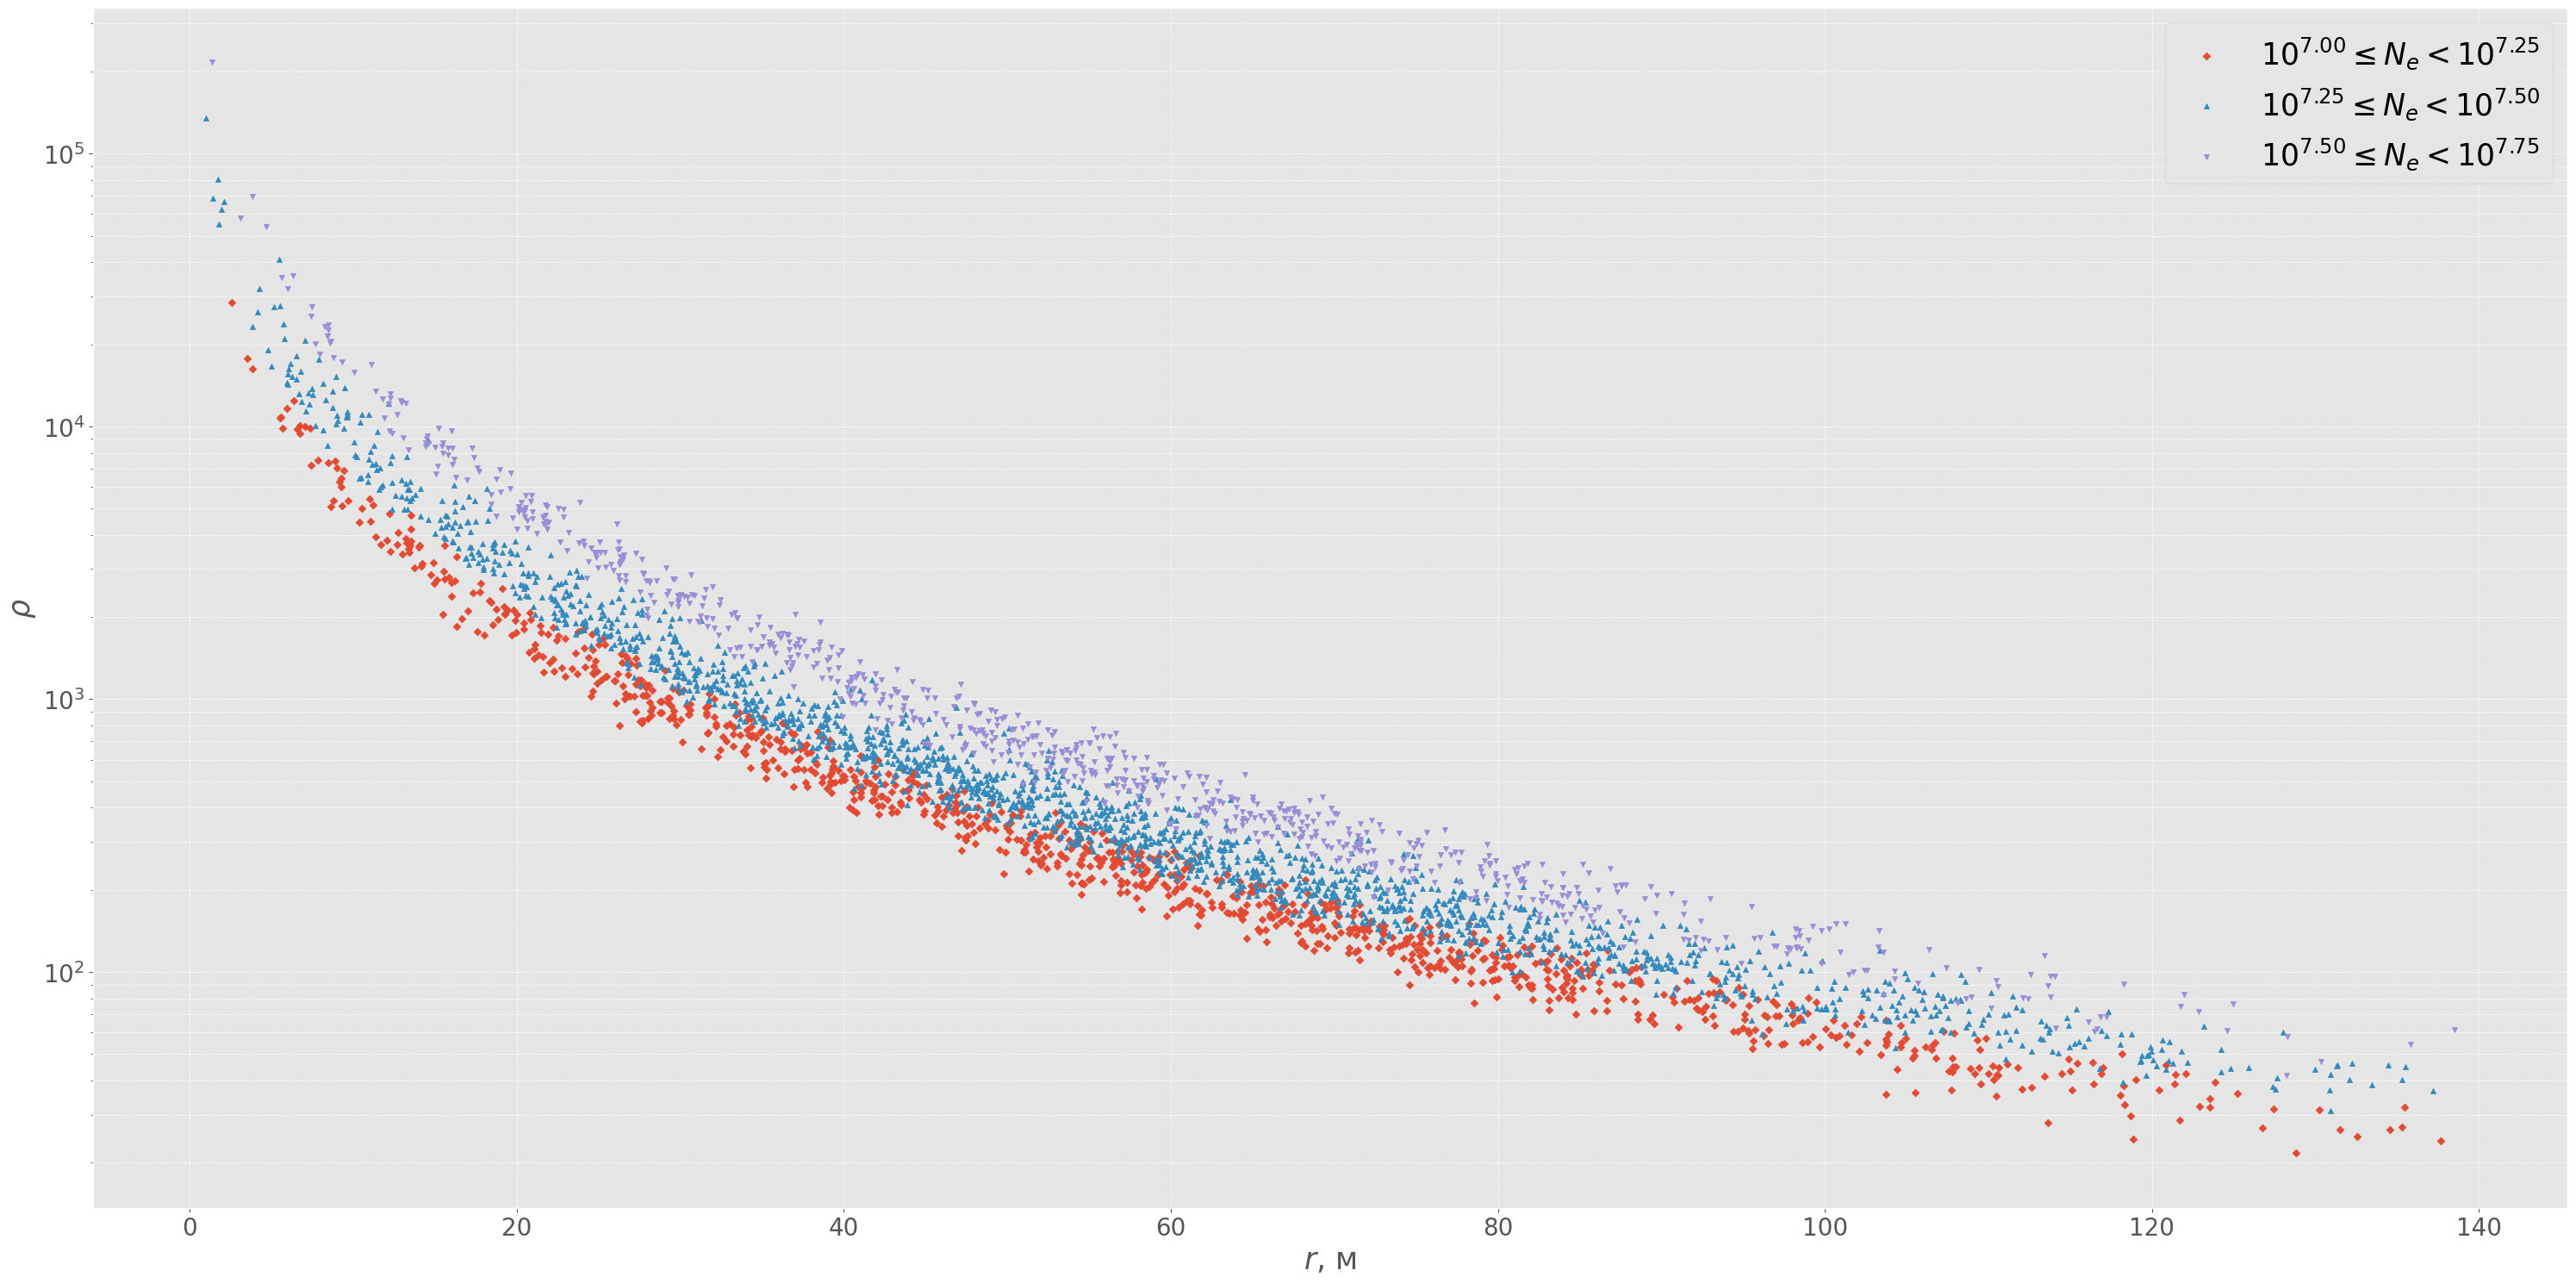

In [231]:
interval_log_Ne = 0.25
intervals = np.arange(6.5, 8, interval_log_Ne)

plt.figure(figsize=(30, 15))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (log_Ne_corsika_array >= lower_bound) & (
        log_Ne_corsika_array < upper_bound)

    r_interval = np.array(r_corsika_array)[mask]
    rho_interval = np.array(rho_corsika_array)[mask]

    if len(r_interval) > 0:
        r_interval = np.concatenate(r_interval)
        rho_interval = np.concatenate(rho_interval)

        marker = markers[i % len(markers)]
        plt.scatter(r_interval, rho_interval, s=20, marker=marker,
                    label=fr"$10^{{{lower_bound:.2f}}} \leq N_e < 10^{{{upper_bound:.2f}}}$")


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


plt.tight_layout()
plt.savefig("plots/pho(r)_Ne_corsika.png", dpi=500, bbox_inches="tight")

# Показать график
plt.show()

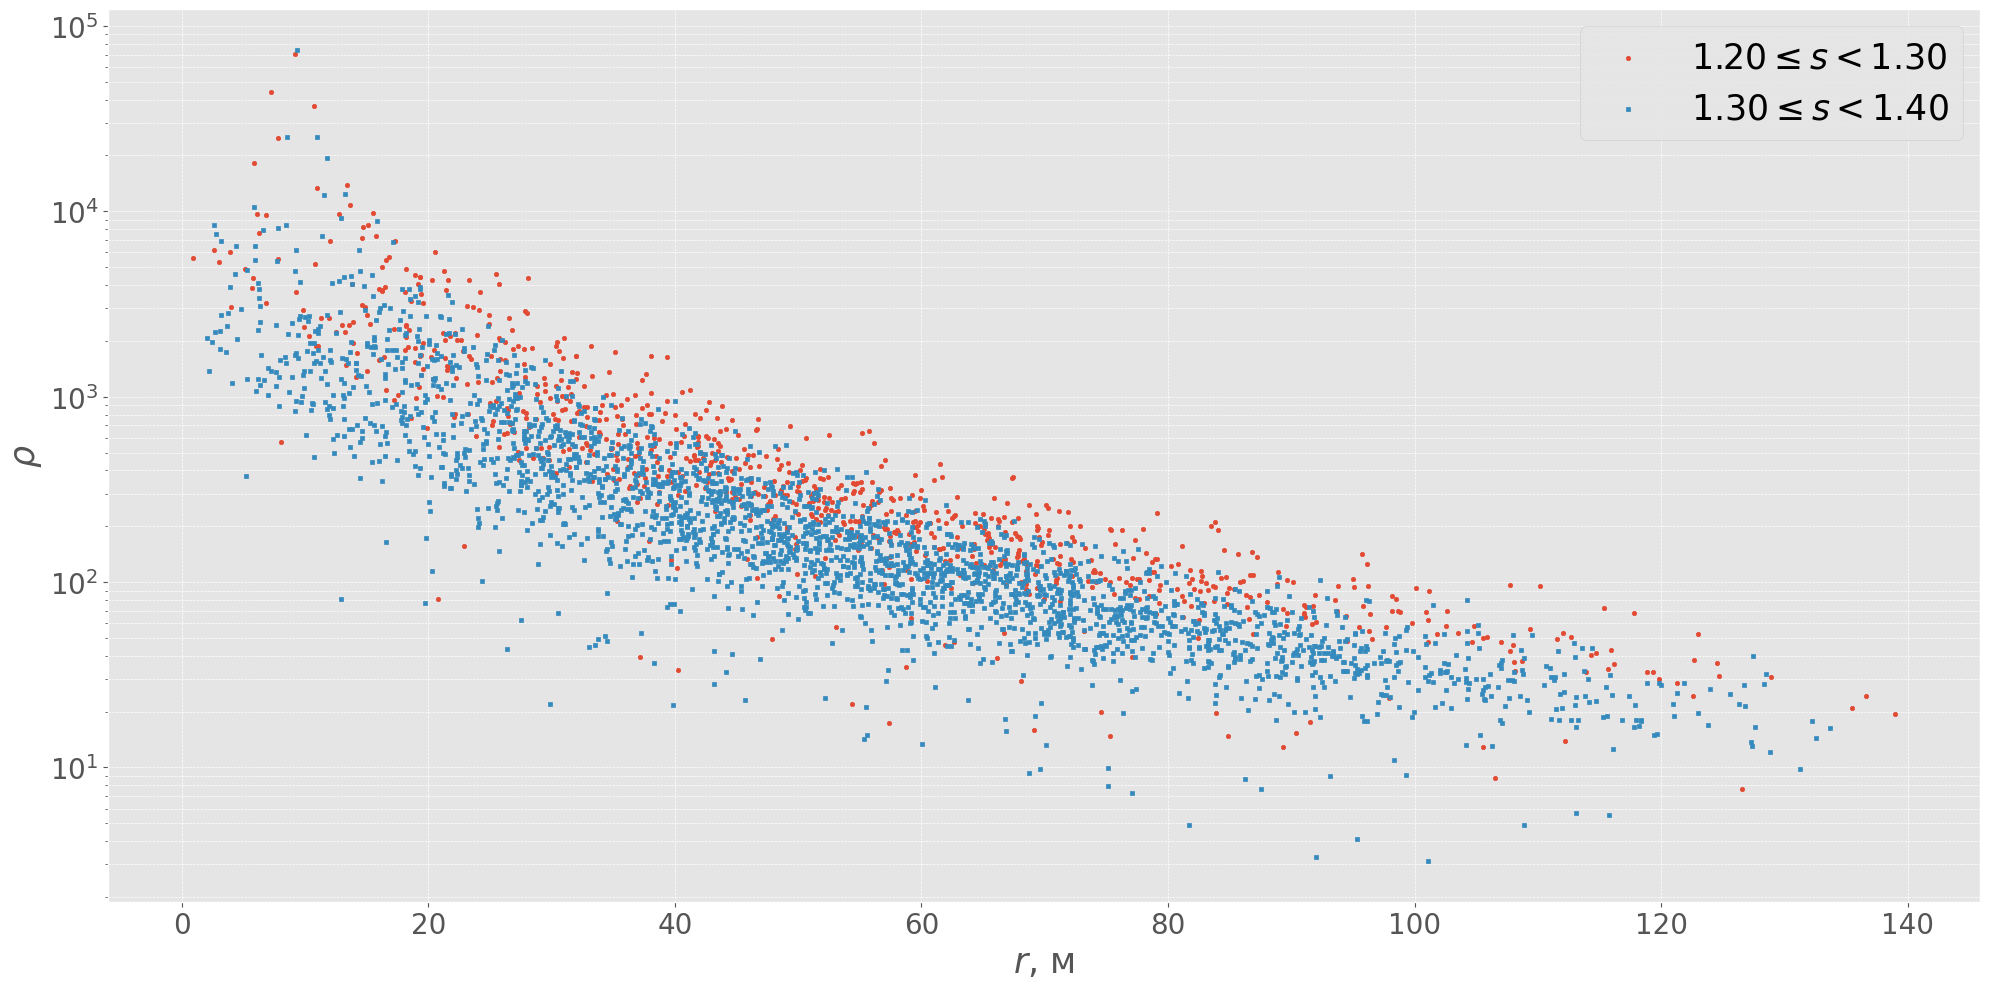

In [281]:
interval_s = 0.1
intervals = np.arange(1.2, 1.41, interval_s)
s_corsika_array = np.array(df['sNKGlong'])

plt.figure(figsize=(20, 10))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (s_corsika_array >= lower_bound) & (
        s_corsika_array < upper_bound)

    r_interval = np.array(r_corsika_array)[mask]
    rho_interval = np.array(rho_corsika_array)[mask]
    if len(r_interval) > 0:
        r_interval = np.concatenate(r_interval)
        rho_interval = np.concatenate(rho_interval)

        marker = markers[i % len(markers)]
        plt.scatter(r_interval, rho_interval, s=10, marker=marker,
                    label=fr"${lower_bound:.2f} \leq s < {upper_bound:.2f}$")

plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/pho(r)_s_corsika.png", dpi=500, bbox_inches="tight")

# Показать график
plt.show()

### восстановленные

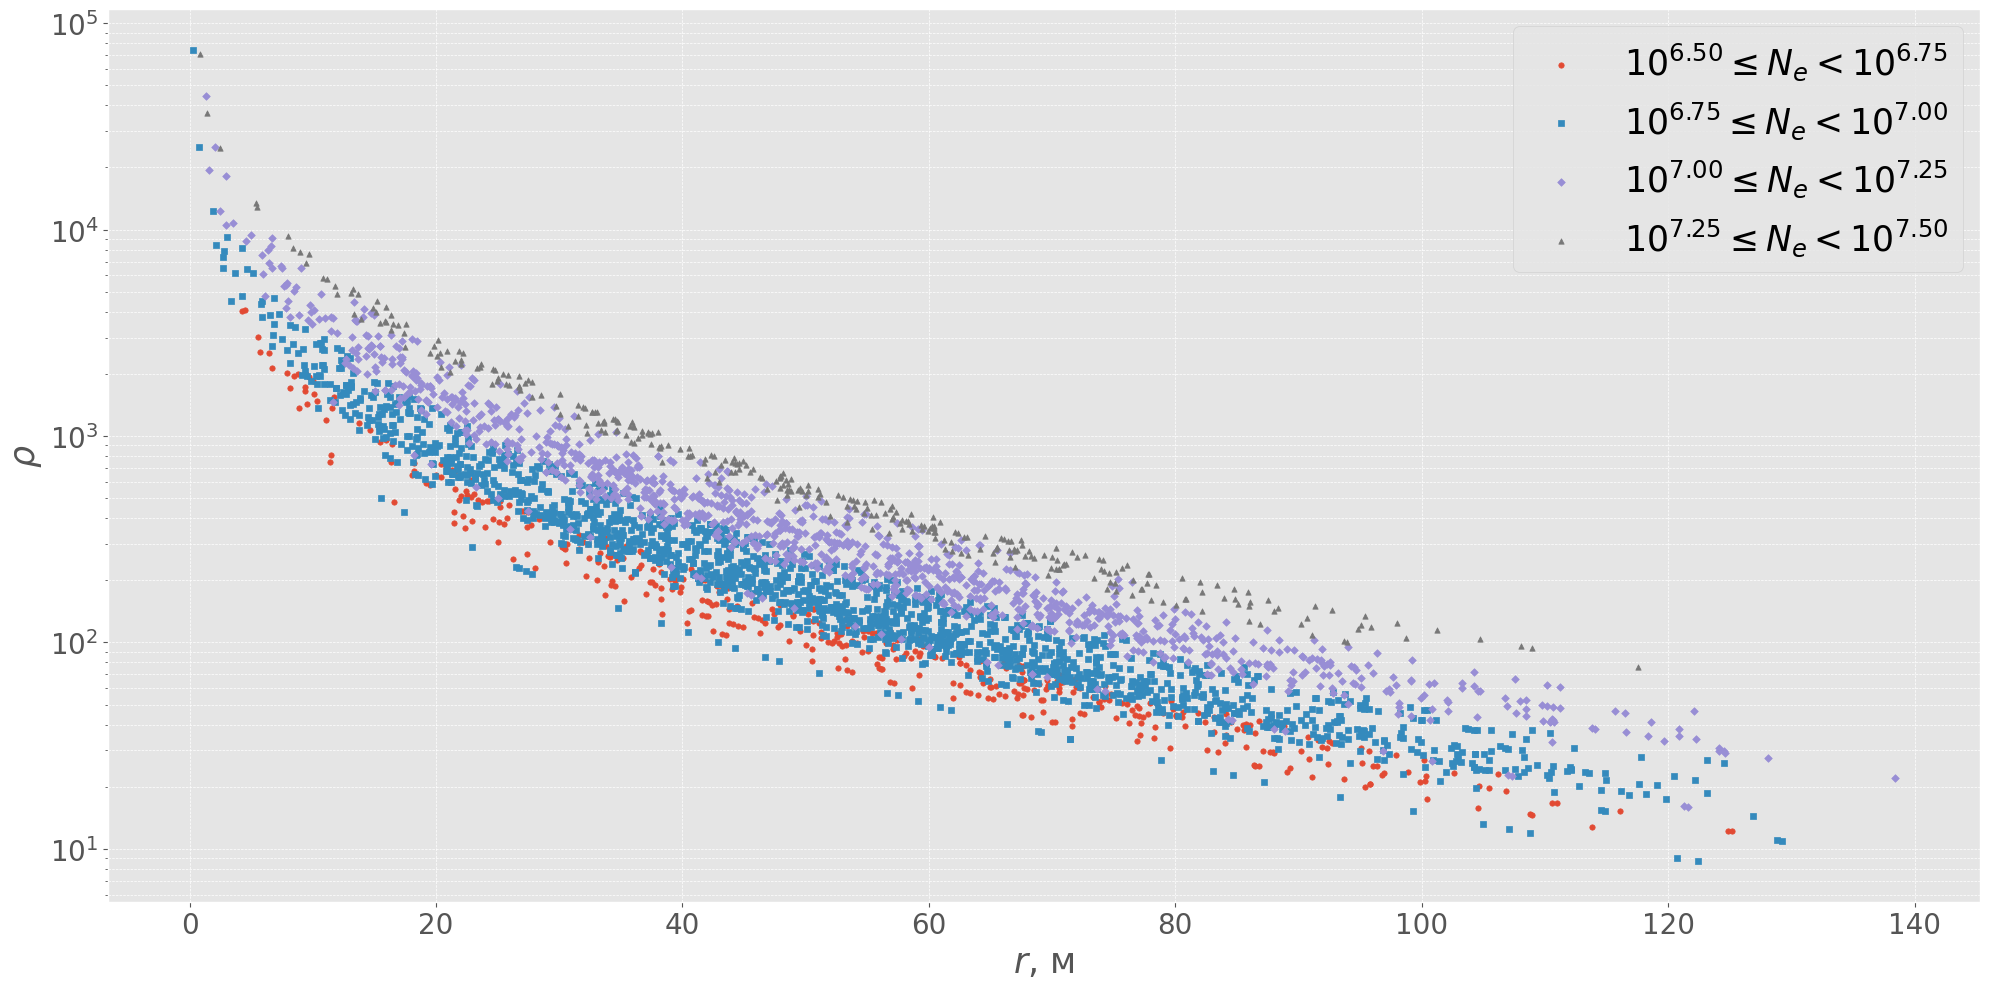

In [282]:
interval_log_Ne = 0.25
intervals = np.arange(6.5, 8, interval_log_Ne)

plt.figure(figsize=(20, 10))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (log_Ne_corsika_array >= lower_bound) & (
        log_Ne_corsika_array < upper_bound)

    r_opt = np.array(r_opt_array)[mask]
    Ne_opt = np.array(Ne_opt_array)[mask]
    s_opt = np.array(s_opt_array)[mask]

    if len(r_opt) > 0:
        rho_fit = np.array([rho_model(r_opt[i], Ne_opt[i], s_opt[i])
                           for i in range(len(r_opt))])

        r_opt = np.concatenate(r_opt)
        rho_fit = np.concatenate(rho_fit)

        marker = markers[i % len(markers)]
        plt.scatter(r_opt, rho_fit, s=15, marker=marker,
                    label=fr"$10^{{{lower_bound:.2f}}} \leq N_e < 10^{{{upper_bound:.2f}}}$")


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/pho(r)_Ne_opt.png", dpi=500, bbox_inches="tight")
plt.show()